In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
%matplotlib inline

In [2]:
# rescale
def rs(x):
    x=x-np.mean(x)
    rx=x/np.std(x)
    return rx

In [3]:
def assign_states(x,nstates):
    xs=np.sort(x)
    xstatestep=len(xs)/nstates
    xinterval=[0]
    for i in range(int(nstates/2-1)):
        xinterval=np.append(xinterval,xs[round(len(xs)/2)+(i+1)*round(xstatestep)])
    xinterval=np.append(xinterval,float('inf'))
    for j in range(int(nstates/2-1)):
        xinterval=np.append(xs[round(len(xs)/2)-(j+1)*round(xstatestep)],xinterval)
    xinterval=np.append(float('-inf'),xinterval)
    xstate=np.zeros(len(x))
    for i in range(len(x)):
        tempinterval=[]
        state=[]
        tempinterval=np.array(xinterval)
        tempinterval=np.append(tempinterval,x[i])
        tempinterval=np.sort(tempinterval)
        state=np.where(tempinterval==x[i])
        xstate[i]=state[0][0]
    xstate = xstate.astype(int)
    
    return xstate

In [4]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MI=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])
        MI[i]=np.sum(MIsingle)
    return timeshift,MI

In [32]:
# Euler method
def ConeOutput(x,phi):
    alpha_c=-9.602*10**-6
    beta_c=7*10**-3 #-1.148*10**-5
    alpha_h=2
    gamma=0.764
    tau_h=1.2
    tau_z=0.5769
    tau_y=0.065
    tau_c=0.05
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    # y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
    # z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    # cone differential equation (include horizontal feedback)
#     phi=1
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    yh=np.zeros(len(x))
    for i in range(len(x)-1): # the length of kernel should be i, original length of kernel is len(Kh)
        dr=(alpha_c*y[i]-(1+beta_c*z[i])*(r[i]+phi*h[i]))*dt/tau_c
        dh=(alpha_h*r[i]-h[i])*dt/tau_h
        r[i+1]=r[i]+dr
        h[i+1]=h[i]+dh
    return r,h

In [7]:
# Runge Kutta method
def ConeOutput_RK(T,x,phi):
    dt=T[1]-T[0]
    alpha_c=-9.602*10**-6
    beta_c=7*10**-3 #-1.148*10**-5
    alpha_h=2
    gamma=0.764
    tau_h=1.2
    tau_z=0.5769
    tau_y=0.065
    tau_c=0.05
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    # y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
    # z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    # cone differential equation (include horizontal feedback)
    #     phi=1

    def drdt(t,rstep,hstep):
        t_index=int(t/dt)-1
        RK_r=(alpha_c*y[t_index]-(1+beta_c*z[t_index])*(rstep+phi*hstep))/tau_c
        return RK_r
    def dhdt(t,rstep,hstep):
        t_index=int(t/dt)-1
        RK_h=(alpha_h*rstep-hstep)/tau_h
        return RK_h
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    for i in range(len(x)-3): # the length of kernel should be i, original length of kernel is len(Kh)
        dh=dt*2
        RK1_r=drdt(T[i],r[i],h[i])
        RK1_h=dhdt(T[i],r[i],h[i])
        RK2_r=drdt(T[i]+dh/2,r[i]+RK1_r/2*dh,h[i]+RK1_h/2*dh)
        RK2_h=drdt(T[i]+dh/2,r[i]+RK1_r/2*dh,h[i]+RK1_h/2*dh)
        RK3_r=drdt(T[i]+dh/2,r[i]+RK2_r/2*dh,h[i]+RK2_h/2*dh)
        RK3_h=drdt(T[i]+dh/2,r[i]+RK2_r/2*dh,h[i]+RK2_h/2*dh)
        RK4_r=drdt(T[i]+dh,r[i]+RK3_r*dh,h[i]+RK3_h*dh)
        RK4_h=drdt(T[i]+dh,r[i]+RK3_r*dh,h[i]+RK3_h*dh)
        r[i+1]=r[i]+1/6*dh*(RK1_r+2*RK2_r+2*RK3_r+RK4_r)
        h[i+1]=h[i]+1/6*dh*(RK1_h+2*RK2_h+2*RK3_h+RK4_h)
    return r,h

In [8]:
# OU
Tot=100
dt=0.001
T=np.arange(dt,Tot,dt)
tau=0.5
D = 4
x=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    x[i+1]=x[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

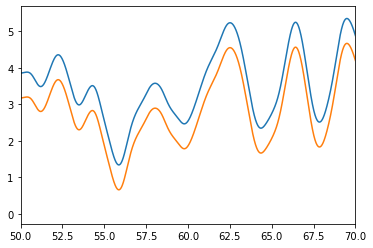

In [34]:
# filtering
fc=0.5
b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, x)
plt.plot(T,x)
plt.xlim(50,70)
x=x-min(x)
plt.plot(T,x)

In [10]:
# two outputs with and without horizontal feedback
r,h=ConeOutput(x,1)
rb,hb=ConeOutput(x,0)

c:\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


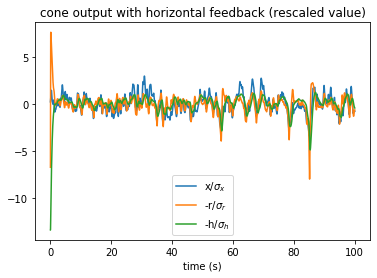

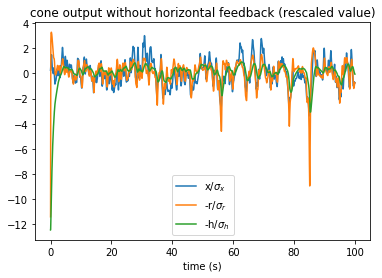

In [11]:
# plot different algorithm 
# plt.plot(T,r/np.std(r))
plt.plot(T,rs(x))
plt.plot(T,-rs(r))
plt.plot(T,-rs(h))
plt.xlim()
plt.legend(('x/$\sigma_x$', '-r/$\sigma_r$', '-h/$\sigma_h$'))
plt.xlabel('time (s)')
plt.title('cone output with horizontal feedback (rescaled value)')
plt.show()

plt.plot(T,rs(x))
plt.plot(T,-rs(rb))
plt.plot(T,-rs(hb))
plt.legend(('x/$\sigma_x$', '-r/$\sigma_r$', '-h/$\sigma_h$'))
plt.xlabel('time (s)')
plt.xlim()
plt.title('cone output without horizontal feedback (rescaled value)')
plt.show()

# plt.savefig('F:/我的雲端硬碟/Retina exp/python code/Drinnenberg 2018/x-r_block.pdf')

In [12]:
# MI of output by Eular method
TS,MI_H=MI(EqualState(x,8),EqualState(r,8),dt,[-2,2])
TS,MI_HB=MI(EqualState(x,8),EqualState(rb,8),dt,[-2,2])

In [13]:
# Runge Kutta ieration
r_RK,h_RK=ConeOutput_RK(T,x,1)
rb_RK,hb_RK=ConeOutput_RK(T,x,0)

(20, 30)

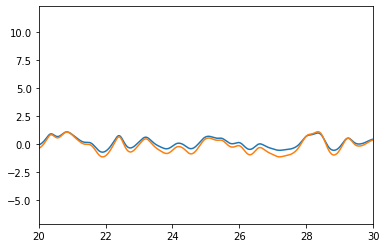

In [14]:
plt.plot(T,rs(r_RK))
plt.plot(T,rs(rb_RK))
plt.xlim(20,30)

In [15]:
# MI of output by Runge Kutta method
TS,MI_RK_H=MI(EqualState(x,8),EqualState(r_RK,8),dt,[-2,2])
TS,MI_RK_HB=MI(EqualState(x,8),EqualState(rb_RK,8),dt,[-2,2])


In [16]:
# plt.plot(TS,MI_RK_H)
# plt.plot(TS,MI_RK_HB)
# plt.plot(TS,MI_H)
# plt.plot(TS,MI_HB)
# plt.xlim(-2,2)

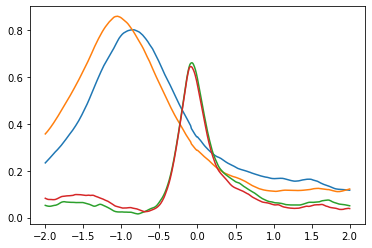

(-4.989000000000001, 104.989)

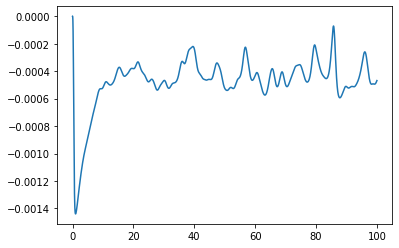

In [37]:
# test two identical stimuli with different time step dt=0.01
x1=x[9:-1:10]
T1=T[9:-1:10]
dt1=T1[1]-T1[0]
r1,h1=ConeOutput(x1,1)
rb1,hb1=ConeOutput(x1,0)
TS1,MI1=MI(EqualState(x1,8),EqualState(r1,8),dt1,[-2,2])
TS1,MIb1=MI(EqualState(x1,8),EqualState(rb1,8),dt1,[-2,2])
plt.plot(TS1,MI1)
plt.plot(TS1,MIb1)
plt.plot(TS,MI_RK_H)
plt.plot(TS,MI_RK_HB)
plt.xlim()
plt.show()

plt.plot(T1,r1)
# plt.plot(T1,x1)
plt.xlim()

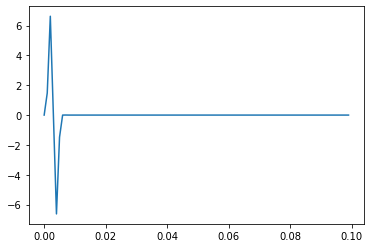

In [20]:
# inner retina process
Tk=np.arange(0,0.1,dt)
mu=3e-3
sigma=1e-3
K1=np.sin(math.pi*Tk/mu)/np.sqrt(2*math.pi*sigma)*np.exp(-1/2*((Tk-mu)/sigma)**2)
plt.plot(Tk,K1)